# EP2 - Cálculo do Conjunto de Mandelbrot em Paralelo com CUDA e OpenMPI

30 de Junho de 2020

## Membros do grupo

| Nome | NUSP |
|------|------|
| Carolina Marques | 10737101 |
| Daniela Favero | 10277443 |
| Miguel Ostrowski | 10723610 |
| Raphael Ribeiro | 10281601 |

## Pacotes Julia

Instalando os pacotes necessários que estão listados no arquivo `Project.toml`:

In [1]:
] up

   Updating registry at `~/.julia/registries/General`


   Updating git-repo `https://github.com/JuliaRegistries/General.git`


   Updating `~/Documentos/USP/concorrente-e-paralela/EP2/Project.toml`
 [no changes]
   Updating `~/Documentos/USP/concorrente-e-paralela/EP2/Manifest.toml`
 [no changes]


Verificando o status dos pacotes:

In [2]:
] st

Status `~/Documentos/USP/concorrente-e-paralela/EP2/Project.toml`
  [336ed68f] CSV v0.6.2
  [a93c6f00] DataFrames v0.21.2
  [31c24e10] Distributions v0.23.4
  [7073ff75] IJulia v1.21.2
  [8314cec4] PGFPlotsX v1.2.8
  [1a8c2f83] Query v0.12.2
  [f3b207a7] StatsPlots v0.14.6


## Compilando

Compilando e executando os códigos C pelo *modo shell*: 


In [3]:
; make all

make: Nothing to be done for 'all'.


In [4]:
; ./Cuda/mandelbrot_cuda -0.188 -0.012 0.554 0.754 4096 4 256

31.459163


Além de imprimir o tempo levado, o programa em C gera a seguinte imagem (gerada no formato ppm, tomamos liberdade para convertê-la para png e exibir aqui):

<img src="output_cuda.png" alt="mandelbrot_cuda" width="400"/>

In [5]:
; mpirun --host localhost:4 ./MPI/mandelbrot_openmpi -0.188 -0.012 0.554 0.754 4096

7.547395


Imagem gerada, novamente a Triple Spiral Valley, dessa vez usando 4 processos com auxílio de OpenMPI:

<img src="output_openmpi.png" alt="mandelbrot_openmpi" width="400"/>

## Experimentos

### Funções úteis

A função abaixo recebe parâmetros `size`, com tamanho da imagem, `file`, com o nome do programa a ser executado e `threads`, com o número de threads do programa paralelo. A função executa o programa `file` com os parâmetros dados e devolve um `DataFrame` com os resultados.

In [50]:
using DataFrames, Query, StatsPlots, Statistics

function measure_mandelbrot(size, file; processes=1, threads=1, blocks=1)
    if file == "MPI/mandelbrot_openmpi"
        results = parse.(Float64,
            split(chomp(read(`mpirun --host localhost:$processes $file -0.188 -0.012 0.554 0.754 $size`, String)), ", "))
        return DataFrame(size = size,
            file = file,
            processes = processes, 
            duration = results[1])
    elseif file == "Cuda/mandelbrot_cuda"
        results = parse.(Float64,
            split(chomp(read(`./$file -0.188 -0.012 0.554 0.754 $size $blocks $threads`, String)), ", "))
        return DataFrame(size = size,
            file = file,
            threads = threads,
            blocks = blocks,
            duration = results[1])
    elseif file == "MPI+Cuda/mandelbrot_openmpi+cuda"
        results = parse.(Float64,
            split(chomp(read(`mpirun --host localhost:$processes $file -0.188 -0.012 0.554 0.754 $size $blocks $threads`, String)), ", "))
        return DataFrame(size = size,
            file = file,
            processes = processes, 
            threads = threads,
            blocks = blocks,
            duration = results[1])
    elseif file == "MPI+OMP/mandelbrot_openmpi+omp"
        results = parse.(Float64,
            split(chomp(read(`mpirun --host localhost:$processes $file -0.188 -0.012 0.554 0.754 $size $threads`, String)), ", "))
        return DataFrame(size = size,
            file = file,
            processes = processes, 
            threads = threads,
            duration = results[1])
    else
        results = parse.(Float64,
            split(chomp(read(`./$file -0.188 -0.012 0.554 0.754 $size $threads`, String)), ", "))
        return DataFrame(size = size,
            file = file,
            threads=threads,
            duration = results[1])
    end
end

measure_mandelbrot (generic function with 1 method)

##TODO: Explicar melhor

A função `run_experiments` recebe os mesmos parâmetros `size`, `file`, e `threads`, e um parâmetro adicional `repetitions`, com o número de repetições de cada experimento com um dado número de `threads`. A função devolve um `DataFrame` com todos os experimentos.

Função adaptada para cuda

In [7]:
using DataFrames
function run_experiments(size, file, threads, repetitions)
    run(`make all`)
    
    results = DataFrame(size = Int[],
        file = String[],
        threads = Int[],
        duration = Float64[])  
    
    for t in threads
        for r in 1:repetitions
            append!(results,
                measure_mandelbrot(size, file, threads=t))    
        end
    end
    return results
end

run_experiments (generic function with 1 method)

In [8]:
function run_experiments_cuda(size, file, threads, blocks, repetitions)
    run(`make all`)
    
    results = DataFrame(size = Int[],
        file = String[],
        threads = Int[],
        blocks = Int[],
        duration = Float64[])  
    
    for t in threads
        for b in blocks
            for r in 1:repetitions
                append!(results,
                    measure_mandelbrot(size, file, threads=t, blocks=b)) 
            end
        end
    end
    return results
end

run_experiments_cuda (generic function with 1 method)

In [9]:
function run_experiments_mpi(size, file, processes, repetitions)
    run(`make all`)
    
    results = DataFrame(size = Int[],
        file = String[],
        processes = Int[],
        duration = Float64[])  
    
    for p in processes
        for r in 1:repetitions
            append!(results,
                measure_mandelbrot(size, file, processes=p)) 
        end
    end
    return results
end

run_experiments_mpi (generic function with 1 method)

In [10]:
function run_experiments_mpicuda(size, file, processes, threads, blocks, repetitions)
    run(`make all`)
    
    results = DataFrame(size = Int[],
        file = String[],
        processes = Int[],
        threads = Int[],
        blocks = Int[],
        duration = Float64[])  
    
    for p in processes
        for t in threads
            for b in blocks
                for r in 1:repetitions
                    append!(results,
                        measure_mandelbrot(size, file, processes=p, threads=t, blocks=b)) 
                end
            end
        end
    end
    return results
end

run_experiments_mpicuda (generic function with 1 method)

In [11]:
function run_experiments_mpiomp(size, file, processes, threads, repetitions)
    run(`make all`)
    
    results = DataFrame(size = Int[],
        file = String[],
        processes = Int[],
        threads = Int[],
        duration = Float64[])  
    
    for p in processes
        for t in threads
            for r in 1:repetitions
                append!(results,
                    measure_mandelbrot(size, file, processes=p, threads=t)) 
            end
        end
    end
    return results
end

run_experiments_mpiomp (generic function with 1 method)

A função `parse_results_threads` recebe um `DataFrame` de resultados, e produzido pela função `run_experiments`. A função devolve um `DataFrame` com a média e o intervalo de confiança da média a 95% dos tempos de execução, agrupados por número de threads. Analogamente para as outras funções.

In [12]:
function parse_results_threads(results)
    parsed_results = results |>
                    @groupby(_.threads) |>
                    @map({threads = key(_),
                          mean_duration = mean(_.duration),
                          ci_duration = 1.96 * std(_.duration)}) |>
                    DataFrame
    
    return parsed_results
end

parse_results_threads (generic function with 1 method)

In [13]:
function parse_results_processes(results)
    parsed_results = results |>
                    @groupby(_.processes) |>
                    @map({processes = key(_),
                          mean_duration = mean(_.duration),
                          ci_duration = 1.96 * std(_.duration)}) |>
                    DataFrame
    
    return parsed_results
end

parse_results_processes (generic function with 1 method)

In [14]:
function parse_results_blocks(results)
    parsed_results = results |>
                    @groupby(_.blocks) |>
                    @map({blocks = key(_),
                          mean_duration = mean(_.duration),
                          ci_duration = 1.96 * std(_.duration)}) |>
                    DataFrame
    
    return parsed_results
end

parse_results_blocks (generic function with 1 method)

A função `save_csv_results`recebe um `DataFrame` e um nome de arquivo, e escreve o `DataFrame` em disco, no formato `.csv`, com o nome passado no argumento. A função `read_csv_results` recebe um nome de arquivo e lê o arquivo correspondente, devolvendo um `DataFrame`.

In [15]:
using CSV

function save_csv_results(data_frame, file)
    CSV.write(file, data_frame)
end

save_csv_results (generic function with 1 method)

In [16]:
using CSV

function read_csv_results(file)
    return CSV.read(file)
end

read_csv_results (generic function with 1 method)

### Sequencial

Realizando os experimentos rodando a célula abaixo.

In [68]:
threads = 1
file = "Sequential/mandelbrot_seq"
size = 4096
repetitions = 15

results = run_experiments(size, file, threads, repetitions)

save_csv_results(results, "CSV/results_seq.csv")

make: Nothing to be done for 'all'.


"results_seq.csv"

### PThreads
Realizando os experimentos rodando a célula abaixo, variando em número de threads.

In [18]:
size = 4096
file = "Pthreads/mandelbrot_pth"
threads = [2 ^ x for x in 0:7]
repetitions = 15

results = run_experiments(size, file, threads, repetitions)
parsed_results = parse_results_threads(results)

save_csv_results(results, "CSV/results_pth_t.csv")
save_csv_results(parsed_results, "CSV/parsed_results_pth_t.csv")

make: Nothing to be done for 'all'.


"CSV/parsed_results_pth_t.csv"

In [ ]:
results = read_csv_results()

Veja no gráfico:

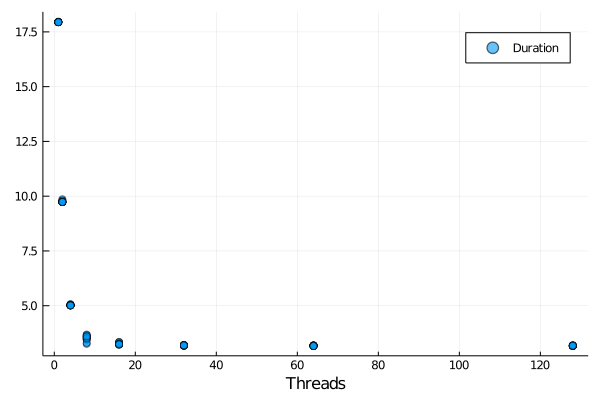

In [19]:
scatter(results.threads, results.duration, xlabel="Threads", alpha = 0.6, labels="Duration")

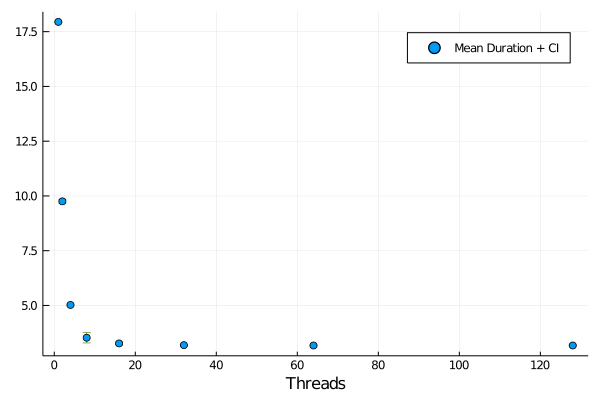

In [20]:
scatter(parsed_results.threads, parsed_results.mean_duration, yerror=parsed_results.ci_duration, xlabel="Threads", labels="Mean Duration + CI")

### OpenMP
Realizando os experimentos rodando a célula abaixo, variando em número de threads.

In [65]:
size = 4096
file = "OMP/mandelbrot_omp"
threads = [2 ^ x for x in 0:7]
repetitions = 15

results = run_experiments(size, file, threads, repetitions)
parsed_results = parse_results_threads(results)

save_csv_results(results, "CSV/results_omp_t.csv")
save_csv_results(parsed_results, "CSV/parsed_results_omp_t.csv")

make: Nothing to be done for 'all'.


"CSV/parsed_results_omp_t.csv"

Veja no gráfico:

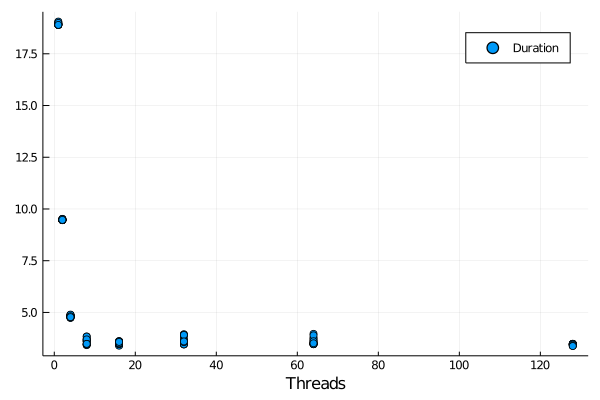

In [66]:
scatter(results.threads, results.duration, xlabel="Threads", labels="Duration")

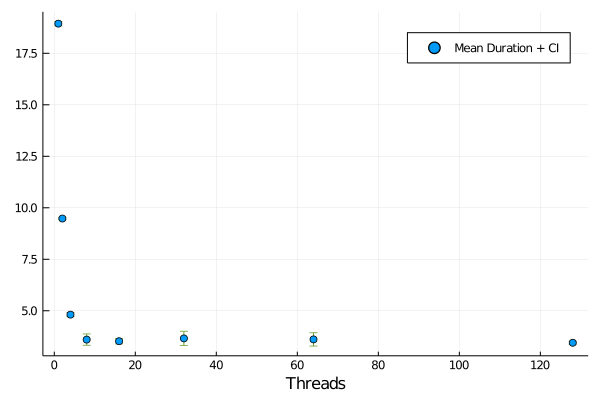

In [67]:
scatter(parsed_results.threads, parsed_results.mean_duration, yerror=parsed_results.ci_duration, xlabel="Threads", labels="Mean Duration + CI")

### CUDA
Realizando os experimentos rodando a célula abaixo, variando em número de blocos e mantendo numero de threads por bloco em 256

In [24]:
size = 4096
file = "Cuda/mandelbrot_cuda"
blocks = [8,16,32,64]
threads = 1024
repetitions = 15

results = run_experiments_cuda(size, file, threads, blocks, repetitions)
parsed_results = parse_results_blocks(results)

save_csv_results(results, "CSV/results_cuda_blocks.csv")
save_csv_results(parsed_results, "CSV/parsed_results_cuda_blocks.csv")

make: Nothing to be done for 'all'.


"CSV/parsed_results_cuda_blocks.csv"

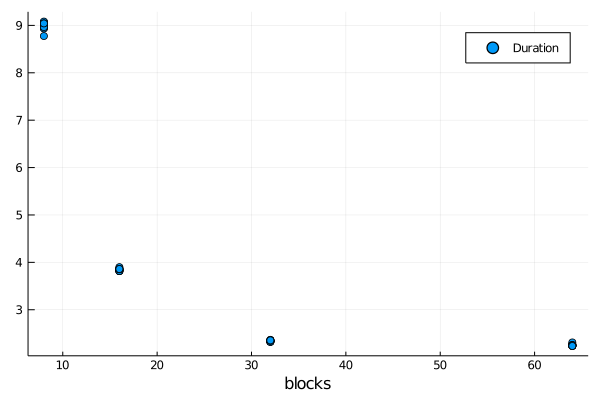

In [25]:
scatter(results.blocks, results.duration, xlabel="blocks", labels="Duration")

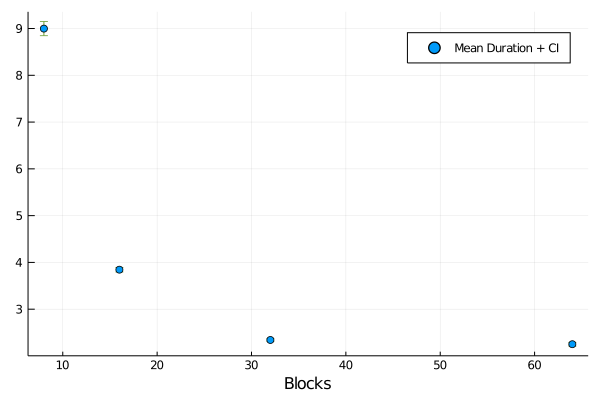

In [26]:
scatter(parsed_results.blocks, parsed_results.mean_duration, yerror=parsed_results.ci_duration, xlabel="Blocks", labels="Mean Duration + CI")

Agora mantemos fixo numero de blocos igual a 4 e variamos o numero de threads por bloco

In [27]:
size = 4096
file = "Cuda/mandelbrot_cuda"
blocks = 64
threads = [2 ^ x for x in 0:11]
repetitions = 15

results = run_experiments_cuda(size, file, threads, blocks, repetitions)
parsed_results = parse_results_threads(results)

save_csv_results(results, "CSV/results_cuda_threads.csv")
save_csv_results(parsed_results, "CSV/parsed_results_cuda_threads.csv")

make: Nothing to be done for 'all'.


"CSV/parsed_results_cuda_threads.csv"

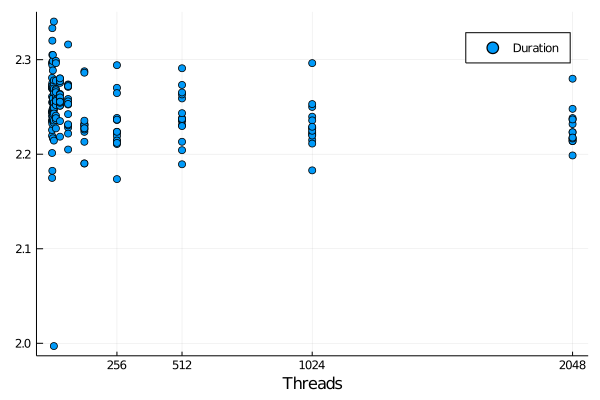

In [28]:
scatter(results.threads, results.duration, xticks=[256,512,1024,2048], xlabel="Threads", labels="Duration")

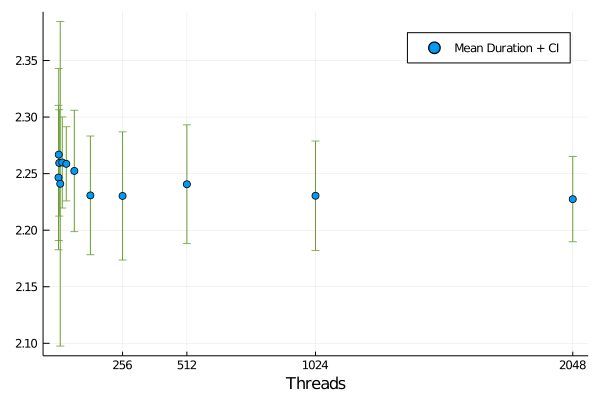

In [29]:
scatter(parsed_results.threads, parsed_results.mean_duration, xticks=[256,512,1024,2048], yerror=parsed_results.ci_duration, xlabel="Threads", labels="Mean Duration + CI")

### OpenMPI
Realizando os experimentos rodando a célula abaixo, variando em número de processos.

In [30]:
size = 4096
file = "MPI/mandelbrot_openmpi"
processes = [1,2,3,4,5] #como estamos rodando em maquina local, valores maiores acabam por matar o programa
repetitions = 15

results = run_experiments_mpi(size, file, processes, repetitions)
parsed_results = parse_results_processes(results)

save_csv_results(results, "CSV/results_openmpi_t.csv")
save_csv_results(parsed_results,"CSV/parsed_results_openmpi_t.csv" )

make: Nothing to be done for 'all'.


"CSV/parsed_results_openmpi_t.csv"

Veja no gráfico:

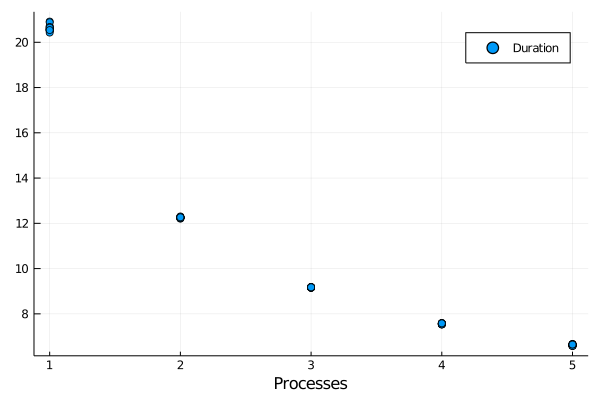

In [31]:
scatter(results.processes, results.duration, xlabel="Processes", labels="Duration")

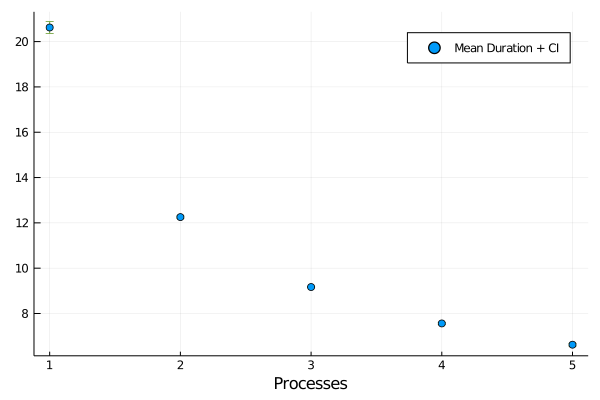

In [32]:
scatter(parsed_results.processes, parsed_results.mean_duration, yerror=parsed_results.ci_duration, xlabel="Processes", labels="Mean Duration + CI")

### OpenMPI + OMP
Realizando os experimentos rodando a célula abaixo, variando em número de procesos, mantendo fixo numero de threads em 4

In [33]:
size = 4096
file = "MPI+OMP/mandelbrot_openmpi+omp"
processes = [1,2,3,4,5]
threads = 4
repetitions = 15

results = run_experiments_mpiomp(size, file, processes, threads, repetitions)
parsed_results = parse_results_processes(results)

save_csv_results(results, "CSV/results_mpi+omp_processes.csv")
save_csv_results(parsed_results, "CSV/parsed_results_mpi+omp_processes.csv")

make: Nothing to be done for 'all'.


"CSV/parsed_results_mpi+omp_processes.csv"

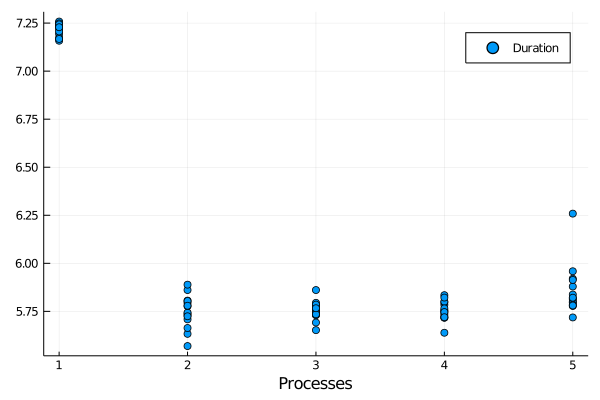

In [34]:
scatter(results.processes, results.duration, xlabel="Processes", labels="Duration")

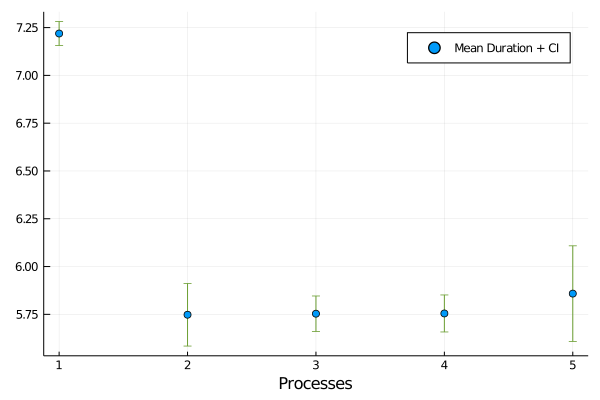

In [35]:
scatter(parsed_results.processes, parsed_results.mean_duration, yerror=parsed_results.ci_duration, xlabel="Processes", labels="Mean Duration + CI")

Agora mantemos fixo o número de processes em 2 e variamos o número de threads

In [36]:
size = 4096
file = "MPI+OMP/mandelbrot_openmpi+omp"
processes = 2
threads = [2 ^ x for x in 0:7]
repetitions = 15

results = run_experiments_mpiomp(size, file, processes, threads, repetitions)
parsed_results = parse_results_threads(results)

save_csv_results(results, "CSV/results_mpi+omp_threads.csv")
save_csv_results(parsed_results, "CSV/parsed_results_mpi+omp_threads.csv")

make: Nothing to be done for 'all'.


"CSV/parsed_results_mpi+omp_threads.csv"

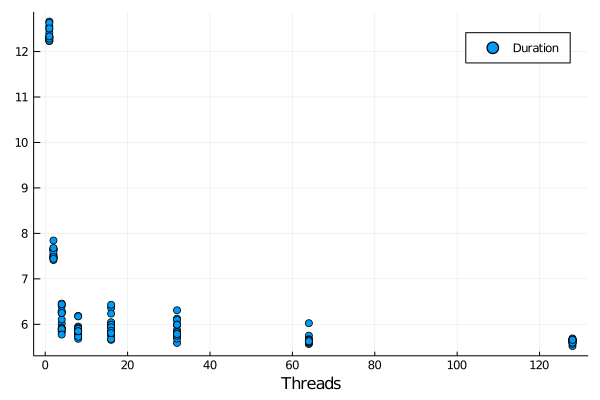

In [37]:
scatter(results.threads, results.duration, xlabel="Threads", labels="Duration")

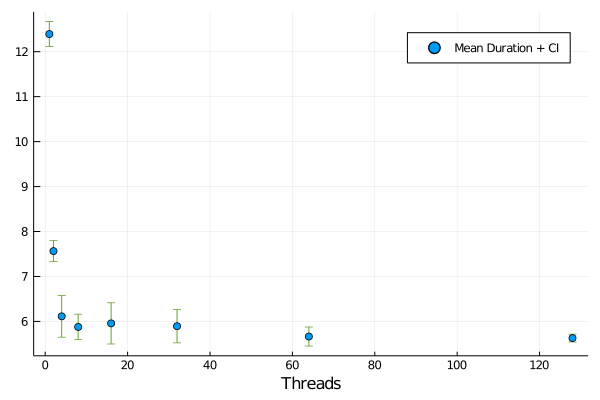

In [38]:
scatter(parsed_results.threads, parsed_results.mean_duration, yerror=parsed_results.ci_duration, xlabel="Threads", labels="Mean Duration + CI")

### OpenMPI + CUDA
Realizando os experimentos rodando a célula abaixo, variando em número de processos, mantendo fixo numero de blocos igual a 16 e numero de threads por bloco em 512.

In [61]:
size = 4096
file = "MPI+Cuda/mandelbrot_openmpi+cuda"
processes = [1,2,3,4]
blocos = 16
threads = 256
repetitions = 15

results = run_experiments_mpicuda(size, file, processes, threads, blocos, repetitions)
parsed_results = parse_results_processes(results)

save_csv_results(results, "CSV/results_mpi+cuda_processes.csv")
save_csv_results(parsed_results, "CSV/parsed_results_mpi+cuda_processes.csv")

make: Nothing to be done for 'all'.


InterruptException: InterruptException:

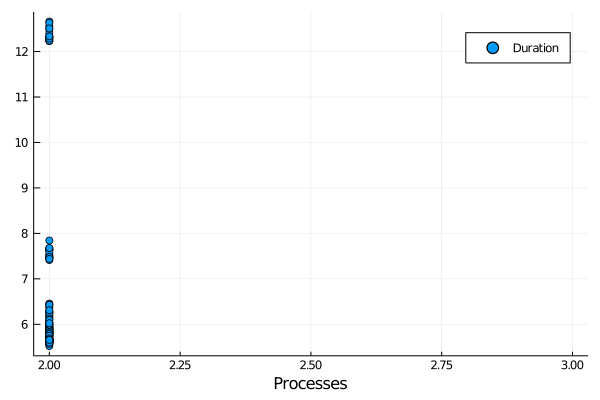

In [52]:
scatter(results.processes, results.duration, xlabel="Processes", labels="Duration")

In [53]:
scatter(parsed_results.processes, parsed_results.mean_duration, yerror=parsed_results.ci_duration, xlabel="Processes", labels="Mean Duration + CI")

ArgumentError: ArgumentError: column name :processes not found in the data frame

Agora mantemos fixo o numero de processos em 2, numero de threads por bloco em 1024, e variamos o numero de blocos

In [54]:
size = 4096
file = "MPI+Cuda/mandelbrot_openmpi+cuda"
processes = 2
blocos = [8,16,32,64]
threads = 1024
repetitions = 15

results = run_experiments_mpicuda(size, file, processes, threads, blocos, repetitions)
parsed_results = parse_results_blocks(results)

save_csv_results(results, "CSV/results_mpi+cuda_blocos.csv")
save_csv_results(parsed_results, "CSV/parsed_results_mpi+cuda_blocos.csv")

make: Nothing to be done for 'all'.


ProcessFailedException: failed process: Process(`mpirun --host localhost:2 MPI+Cuda/mandelbrot_openmpi+cuda -0.188 -0.012 0.554 0.754 4096 8 1024`, ProcessExited(1)) [1]


In [55]:
scatter(results.blocks, results.duration, xlabel="Blocks", labels="Duration")

ArgumentError: ArgumentError: column name :blocks not found in the data frame

In [56]:
scatter(parsed_results.blocks, parsed_results.mean_duration, yerror=parsed_results.ci_duration, xlabel="Blocks", labels="Mean Duration + CI")

ArgumentError: ArgumentError: column name :blocks not found in the data frame

Agora mantemos fixo o numero de processos em 2, numero de blocos em 4, e variamos o numero de threads por bloco.

In [57]:
size = 4096
file = "MPI+Cuda/mandelbrot_openmpi+cuda"
processes = 2
blocos = 32
threads = [2 ^ x for x in 0:11]
repetitions = 15

results = run_experiments_mpicuda(size, file, processes, threads, blocos, repetitions)
parsed_results = parse_results_threads(results)

save_csv_results(results, "CSV/results_mpi+cuda_threads.csv")
save_csv_results(parsed_results, "CSV/parsed_results_mpicuda_threads.csv")

make: Nothing to be done for 'all'.


InterruptException: InterruptException:

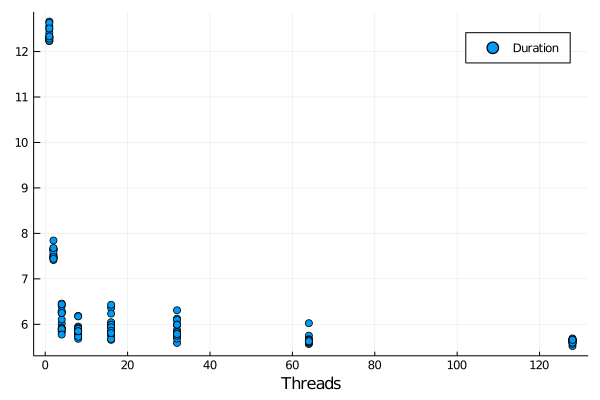

In [58]:
scatter(results.threads, results.duration, xlabel="Threads", labels="Duration")

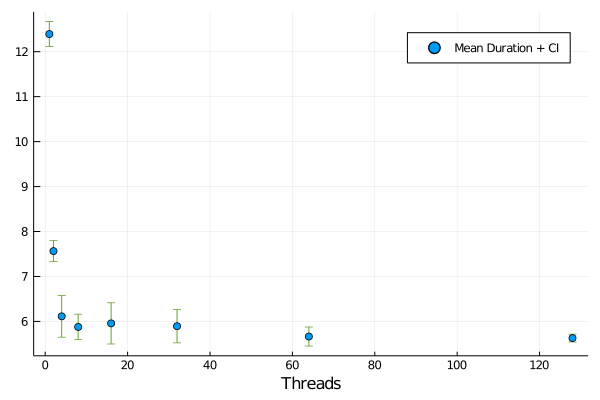

In [59]:
scatter(parsed_results.threads, parsed_results.mean_duration, yerror=parsed_results.ci_duration, xlabel="Threads", labels="Mean Duration + CI")

## Discussão

### Determinação de parâmetros

**OpenMP**
Observamos que o tempo diminui até 8 threads, não apresentando grandes mudanças a partir de então. O ponto onde ocorre menor intervalo de confiança é com 16 threads.

**PThreads**
Podemos observar uma diminuição significativa do tempo até 32 threads, onde, a partir desse ponto, ocorre uma estabilização no tempo. Portanto, 32 threads é o número ideal.

**OpenMPI**
Ocorre uma diminuição do tempo de execução até 6 processos. Como os experimentos foram realizados localmente, não foi possível testar para valores maiores. Tomamos 6 processos como parâmetro ideal.

**Cuda**
Quanto número de blocos, é claro a diminuição significativa do tempo conforme o aumento do número de blocos, atingindo um ponto ótimo em 64 blocos. Já no número de threads, não percebemos uma melhora significativa no tempo de execução. Por outro lado, conforme o número de threads aumenta, o intervalo de confiança diminui. 2048 Threads é o parâmetro ótimo encontrado.

**OpenMPI + OMP**
Notamos uma diminuição do tempo significativa de 1 processo para 2. A partir de 2 processos, percebemos um aumento do intervalo de confiança, o que mostra valores mais distribuidos e piores que para 2 processos. Tal fênomeno pode ser explicado devido ao fato dos experimentos terem sido realizados localmente e ocorrer uma disputa de threads entre as duas bibliotecas.

### Comparação entre as implementações
Entre OpenMP e Pthreads, o desempenho é muito próximo sendo o OpenMP sutilmente melhor, com menor intervalo de confiança e tempos melhores em seus parâmetros escolhidos. Isso ocorre pois ambos utilizam o mesmo paradigma de computação paralela. 
Já entre Cuda e OpenMPI, o cuda é claramente melhor, mesmo em parâmetros não-ótimos. Como explicado anteriormente, isso ocorre pois os experimentos foram realizados localmente. 
O Cuda supera também o OpenMP e Pthreads. Possivelmente por utilizar outro paradigma de computação paralela assim como depender de outro hardware.
O OpenMPI apresenta tempo de execução pior que o sequencial para 1 processo, superando-o a partir de 2 processos. Com 5 processos, supera o OpenMP e Pthreads.

### Observações

Notamos que o CUDA apresenta um tempo de execução muito melhor quando o número de blocos é múltiplo de 8.